# Refining posterior estimates with importance sampling

## Theory

SBI estimates the posterior $p(\theta|x) = {p(\theta)p(x|\theta)}/{p(x)}$ based on samples from the prior $\theta\sim p(\theta)$ and the likelihood $x\sim p(x|\theta)$. Sometimes, we can do both, *sample* and *evaluate* the prior and likelihood. In this case, we can combine the *simulation-based* estimate $q(\theta|x)$ with *likelihood-based* importance sampling, and thereby generate an asymptotically exact estimate for $p(\theta|x)$.

### Importance weights

The main idea is to interpret $q(\theta|x)$ as a proposal distribution and generate proposal samples $\theta_i\sim q(\theta|x)$, and then augment each sample with an importance weight $w_i = p(\theta_i|x) / q(\theta_i|x)$. The definition of the importance weights is motivated from Monte Carlo estimates for the random variable $f(\theta)$, 

$$ 
\mathbb{E}_{\theta\sim p(\theta|x)}\left[f(\theta)\right] 
=\int p(\theta|x) f(\theta)\,\text{d}\theta
\approx \sum_{\theta_i\sim p(\theta_i|x)} f(\theta_i).
$$

We can rewrite this expression as 

$$ 
\mathbb{E}_{\theta\sim p(\theta|x)}\left[f(\theta)\right] 
=\int p(\theta|x) f(\theta)\,\text{d}\theta
=\int q(\theta|x) \frac{p(\theta|x)}{q(\theta|x)}f(\theta)\,\text{d}\theta
\approx \sum_{\theta_i\sim q(\theta_i|x)} \frac{p(\theta_i|x)}{q(\theta_i|x)}f(\theta_i)
\approx \sum_{\theta_i\sim q(\theta_i|x)} w_i\cdot f(\theta_i).
$$

Instead of sampling $\theta_i\sim p(\theta_i|x)$, we can thus sample $\theta_i\sim q(\theta_i|x)$ and attach a corresponding importance weight $w_i$ to each sample. Intuitively, the importance weights downweight samples where $q(\theta|x)$ overestimates $p(\theta|x)$ and upweight samples where $p(\theta|x)$ underestimates $q(\theta|x)$.

## Implementation

In [1]:
import torch
from torch import eye, ones
from torch.distributions import MultivariateNormal

from sbi.analysis import marginal_plot
from sbi.inference import NPE, ImportanceSamplingPosterior
from sbi.utils import BoxUniform

We first define a simulator and a prior which both have a `sample` function (as required for `sbi`) and `log_prob` evaluations (as required for importance sampling).

Next we train an NPE model for inference.

Now we perfrom inference with the model.

In [2]:
# define prior and simulator
class Simulator:
    def __init__(self):
        pass

    def log_likelihood(self, theta, x):
        return MultivariateNormal(theta, eye(2)).log_prob(x)

    def sample(self, theta):
        return theta + torch.randn((theta.shape))

prior = BoxUniform(-5 * ones((2,)), 5 * ones((2,)))
sim = Simulator()
log_prob_fn = lambda theta, x_o: sim.log_likelihood(theta, x_o) + prior.log_prob(theta)

# generate train data
_ = torch.manual_seed(3)
theta = prior.sample((10,))
x = sim.sample(theta)

# train NPE model
_ = torch.manual_seed(4)
inference = NPE(prior=prior)
_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()

# generate a synthetic observation
_ = torch.manual_seed(2)
theta_gt = prior.sample((1,))
observation = sim.sample(theta_gt)[0]
posterior = posterior.set_default_x(observation)
print("observations.shape", observation.shape)

# sample from posterior
theta_inferred = posterior.sample((10_000,))

# get samples from ground-truth posterior
gt_samples = MultivariateNormal(observation, eye(2)).sample((len(theta_inferred) * 5,))
gt_samples = gt_samples[prior.support.check(gt_samples)][:len(theta_inferred)]

 Neural network successfully converged after 70 epochs.observations.shape torch.Size([2])


In this case, we know the ground truth posterior, so we can compare NPE to it:

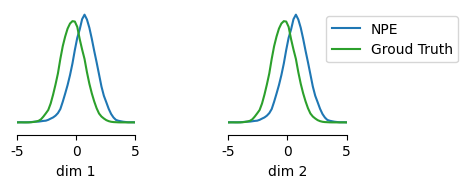

In [17]:
fig, ax = marginal_plot(
    [theta_inferred, gt_samples],
    limits=[[-5, 5], [-5, 5]],
    figsize=(5, 1.5),
    diag="kde",  # smooth histogram
)
ax[1].legend(["NPE", "Groud Truth"], loc="upper right", bbox_to_anchor=[2.0, 1.0, 0.0, 0.0]);

While NPE is not completely off, it does not provide a perfect fit to the posterior. In cases where the likelihood is tractable, we can fix this with importance sampling.

### Importance sampling with the SBI toolbox

With the `sbi` toolbox, importance sampling is a one-liner. `sbi` supports two methods
for importance sampling:
- `"importance"`: returns `n_samples` weighted samples (as above) corresponding to
  `n_samples * sample_efficiency` samples from the posterior. This results in unbiased
  samples, but the number of effective samples may be small when the `sbi` estimate is
  inaccurate.
- `"sir"` (sampling-importance-resampling): performs rejection sampling on a batched
  basis with batch size `oversampling_factor`.  This is a guaranteed way to obtain `N /
  oversampling_factor` samples, but these may be biased as the weight normalization is
  not performed across the entire set of samples.

In [14]:
posterior_sir = ImportanceSamplingPosterior(
    potential_fn=log_prob_fn,
    proposal=posterior,
    method="sir",
).set_default_x(observation)

theta_inferred_sir = posterior_sir.sample(
    (1000,),
    oversampling_factor=32,
)

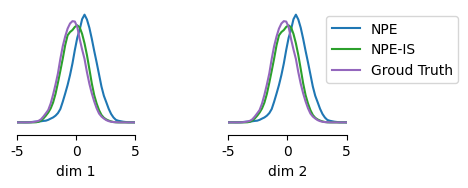

In [16]:
fig, ax = marginal_plot(
    [theta_inferred, theta_inferred_sir, gt_samples],
    limits=[[-5, 5], [-5, 5]],
    figsize=(5, 1.5),
    diag="kde",  # smooth histogram
)
ax[1].legend(["NPE", "NPE-IS", "Groud Truth"], loc="upper right", bbox_to_anchor=[2.0, 1.0, 0.0, 0.0]);

Indeed, the importance-sampled posterior matches the ground truth well, despite significant deviations of the initial NPE estimate.